# 타이타닉 생존률 예측


## 목차
### 1. 데이터 불러오기  
### 2. 피처 엔지니어링  
<li>null값 채우기</li>
<li>레이블 인코딩</li> 

### 3. 모델 학습

## 데이터 불러오기

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import missingno as msno

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [45]:
train = pd.read_csv('train.csv', index_col=['PassengerId'])
test = pd.read_csv('test.csv', index_col=['PassengerId'])

(891, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<AxesSubplot:>

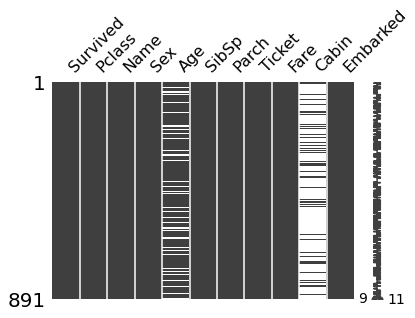

In [46]:
print(train.shape)
train.info()

msno.matrix(train, figsize=(6,4))

In [47]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

(418, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


<AxesSubplot:>

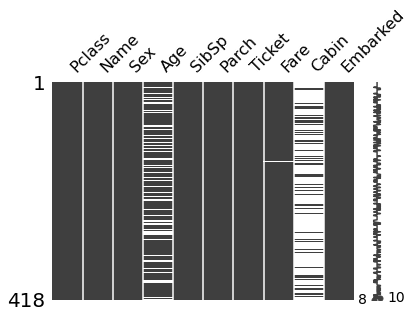

In [48]:
print(test.shape)
test.info()
msno.matrix(test, figsize=(6,4))

In [49]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

train에는 age, cabin, embarked  
test에는 fare, age, cabin 칼럼에 null값 존재

## 피처 엔지니어링

### null값 채우기

In [50]:
# test Fare는 하나만 null이므로 0으로 대체
test['Fare'].fillna(0, inplace=True)
test['Fare'].isna().sum()

0

In [51]:
# Embarked는 가장 많이 나온 값으로 대체
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [52]:
train['Embarked'].fillna('S', inplace=True)

train['Embarked'] = train['Embarked'].astype('category').cat.codes
test['Embarked'] = test['Embarked'].astype('category').cat.codes

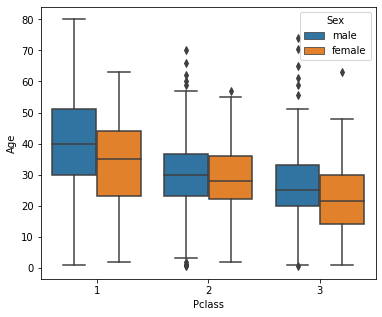

In [53]:
# pclass 별, 성별에 따른 나이 확인
plt.figure(figsize=(6,5))
sns.boxplot(x='Pclass', y='Age',hue='Sex', data=train)
plt.show()

In [54]:
# 성별, plcass나이 평균값으로 대체
mean_by_P = train.groupby(['Pclass','Sex'])['Age'].mean()
mean_by_P

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [55]:
train.loc[(train['Pclass']==1)&(train['Sex']=='male')&(train['Age'].isna()), 'Age']=mean_by_P[1]['male']
train.loc[(train['Pclass']==1)&(train['Sex']=='female')&(train['Age'].isna()), 'Age']=mean_by_P[1]['female']

train.loc[(train['Pclass']==2)&(train['Sex']=='male')&(train['Age'].isna()), 'Age']=mean_by_P[2]['male']
train.loc[(train['Pclass']==2)&(train['Sex']=='female')&(train['Age'].isna()), 'Age']=mean_by_P[2]['female']

train.loc[(train['Pclass']==3)&(train['Sex']=='male')&(train['Age'].isna()), 'Age']=mean_by_P[3]['male']
train.loc[(train['Pclass']==3)&(train['Sex']=='female')&(train['Age'].isna()), 'Age']=mean_by_P[3]['female']

train['Age'].isna().sum()

0

In [56]:
test.loc[(test['Pclass']==1)&(test['Sex']=='male')&(test['Age'].isna()), 'Age']=mean_by_P[1]['male']
test.loc[(test['Pclass']==1)&(test['Sex']=='female')&(test['Age'].isna()), 'Age']=mean_by_P[1]['female']

test.loc[(test['Pclass']==2)&(test['Sex']=='male')&(test['Age'].isna()), 'Age']=mean_by_P[2]['male']
test.loc[(test['Pclass']==2)&(test['Sex']=='female')&(test['Age'].isna()), 'Age']=mean_by_P[2]['female']

test.loc[(test['Pclass']==3)&(test['Sex']=='male')&(test['Age'].isna()), 'Age']=mean_by_P[3]['male']
test.loc[(test['Pclass']==3)&(test['Sex']=='female')&(test['Age'].isna()), 'Age']=mean_by_P[3]['female']

test['Age'].isna().sum()

0

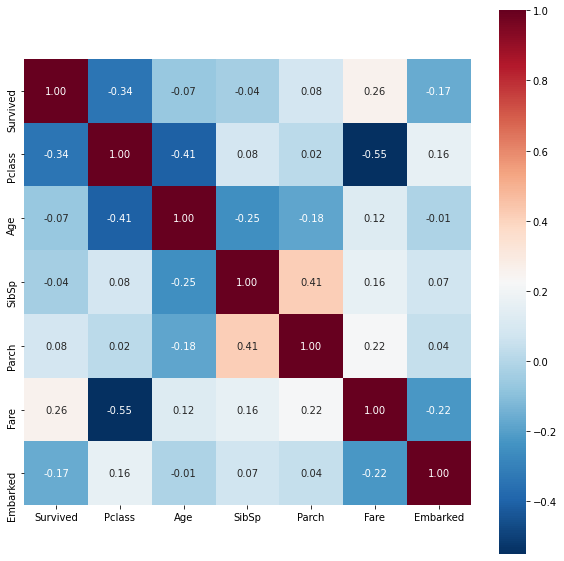

In [57]:
# heatmap을 그려 상관도를 분석
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='RdBu_r', square=True, cbar=True, annot=True, fmt=".2f")
plt.show()

<img src="TITANIC/class.png" width="50%" >  

등급 별, 요금에 따른 자리가 5개씩 나뉩니다

<a href='https://www.statisticalconsultants.co.nz/blog/titanic-fare-data.html'>
출처: Statistical Consultants Ltd</a>

In [58]:
# Pclass 별 fare에 따라 자리가 5개로 나뉨
df=pd.qcut(train['Fare'], 5)
df.unique()

[(-0.001, 7.854], (39.688, 512.329], (7.854, 10.5], (10.5, 21.679], (21.679, 39.688]]
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

<AxesSubplot:xlabel='fare_by_class', ylabel='Density'>

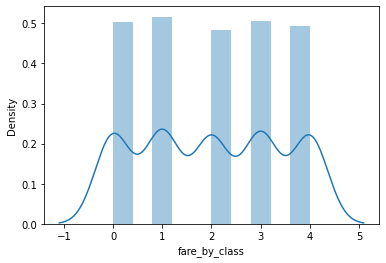

In [59]:
train['fare_by_class']=pd.qcut(train['Fare'], 5)
test['fare_by_class']=pd.qcut(test['Fare'], 5)

train['fare_by_class']=train['fare_by_class'].astype('category').cat.codes
test['fare_by_class']=test['fare_by_class'].astype('category').cat.codes

sns.distplot(train['fare_by_class'])

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

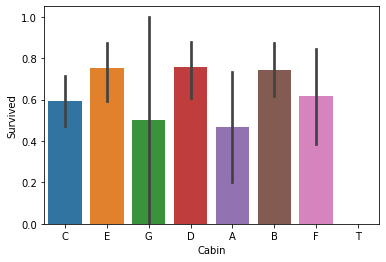

In [60]:
train['Cabin']=train['Cabin'].str[0]
test['Cabin']=test['Cabin'].str[0]

# cabin에 따른 생존
sns.barplot(x=train['Cabin'], y=train['Survived'])

In [61]:
train.groupby('Pclass')['Cabin'].value_counts()

Pclass  Cabin
1       C        59
        B        47
        D        29
        E        25
        A        15
        T         1
2       F         8
        D         4
        E         4
3       F         5
        G         4
        E         3
Name: Cabin, dtype: int64

In [62]:
# 등급별 가장 많이 나온 cabin 값으로 채웁니다
train.loc[(train['Pclass']==1)&(train['Cabin'].isnull()), 'Cabin']='C'
train.loc[(train['Pclass']==2)&(train['Cabin'].isnull()), 'Cabin']='F'
train.loc[(train['Pclass']==3)&(train['Cabin'].isnull()), 'Cabin']='F'

train['Cabin'].isna().sum()

0

In [63]:
test.loc[(test['Pclass']==1)&(test['Cabin'].isnull()), 'Cabin']='C'
test.loc[(test['Pclass']==2)&(test['Cabin'].isnull()), 'Cabin']='F'
test.loc[(test['Pclass']==3)&(test['Cabin'].isnull()), 'Cabin']='F'

test['Cabin'].isna().sum()

0

In [64]:
print(test.isna().sum())

Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
fare_by_class    0
dtype: int64


In [65]:
# 호칭을 Title 칼럼에 추가

def change_name(name):
    return name.split(',')[1].split('.')[0].strip()

train['Title']=train['Name'].apply(change_name)
test['Title']=test['Name'].apply(change_name)

In [66]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
the Countess      1
Capt              1
Jonkheer          1
Sir               1
Mme               1
Ms                1
Lady              1
Don               1
Name: Title, dtype: int64


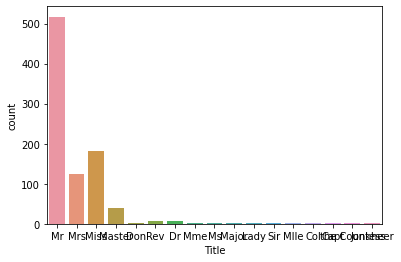

In [67]:
print(train['Title'].value_counts())
sns.countplot(train.Title)
plt.show()

In [68]:
# 'Mr', 'Master', 'Mrs', 'Miss'이외는 other로 저장
def change_title(title):
    if title in ['Mr', 'Master', 'Mrs', 'Miss']:
        return title
    else:
        return 'other'

train['Title']=train['Title'].apply(change_title)
test['Title']=test['Title'].apply(change_title)

In [69]:
train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'other'], dtype=object)

<AxesSubplot:xlabel='Age', ylabel='Count'>

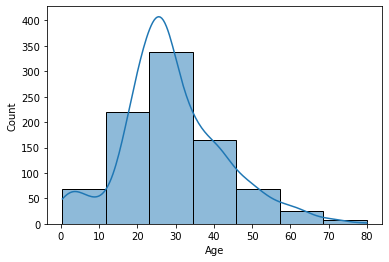

In [70]:
# 나이를 범주화 하기 위해 bins를 다양하게 그려 확인
sns.histplot(train['Age'], bins=7, kde=True)

<AxesSubplot:xlabel='age_cat'>

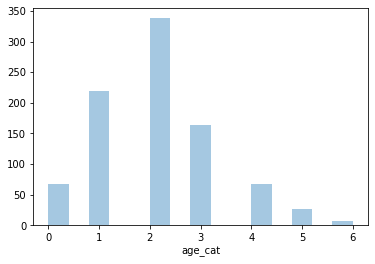

In [71]:
# bins=7일 때 정규분포를 이뤄서 7개씩 범주화
train['age_cat']=pd.cut(train['Age'], 7)
test['age_cat']=pd.cut(test['Age'], 7)

train['age_cat'] = train['age_cat'].astype('category').cat.codes
test['age_cat'] = test['age_cat'].astype('category').cat.codes

sns.distplot(train['age_cat'], kde=False)

In [72]:
train['Family']=train['SibSp']+train['Parch']+1
test['Family']=test['SibSp']+test['Parch']+1
train['Family']

PassengerId
1      2
2      2
3      1
4      2
5      1
      ..
887    1
888    1
889    4
890    1
891    1
Name: Family, Length: 891, dtype: int64

In [73]:
train[['Pclass','Cabin','Embarked','fare_by_class','Title','age_cat','Family','Sex']].head(3)

,Pclass,Cabin,Embarked,fare_by_class,Title,age_cat,Family,Sex
PassengerId,,,,,,,,
1,3,F,2,0,Mr,1,2,male
2,1,C,0,4,Mrs,3,2,female
3,3,F,2,1,Miss,2,1,female


## 데이터 레이블 인코딩

In [74]:
train['Cabin'] = train['Cabin'].astype('category').cat.codes
test['Cabin'] = test['Cabin'].astype('category').cat.codes

train['Title'] = train['Title'].astype('category').cat.codes
test['Title'] = test['Title'].astype('category').cat.codes

train['Sex'] = train['Sex'].astype('category').cat.codes
test['Sex'] = test['Sex'].astype('category').cat.codes

In [75]:
survived=train[train['Survived']==1]

print('<각 데이터 별 unique값>','train: ',train['Family'].unique(),'test: ',test['Family'].unique(),sep='\n')

survived.groupby('Family')['Survived'].count()

<각 데이터 별 unique값>
train: 
[ 2  1  5  3  7  6  4  8 11]
test: 
[ 1  2  3  5  4  6  8  7 11]


Family
1    163
2     89
3     59
4     21
5      3
6      3
7      4
Name: Survived, dtype: int64

In [76]:
# family 5,6,7은 생존자 수가 비슷해서 1로 통일, 나머지 비슷한 값은 0으로 통일
resize={
    1: 8,
    2: 6,
    3: 4,
    4: 2,
    5: 1,
    6: 1,
    7: 1,
    8: 0,
    11: 0
}

train['Family']=train['Family'].apply(lambda x: resize[x])
test['Family']=test['Family'].apply(lambda x: resize[x])

In [77]:
print('<각 데이터 별 unique값>','train: ',train['Cabin'].unique(),'test: ',test['Cabin'].unique(),sep='\n')

survived.groupby('Cabin')['Survived'].count()

<각 데이터 별 unique값>
train: 
[5 2 4 6 3 0 1 7]
test: 
[5 2 1 4 0 3 6]


Cabin
0      7
1     35
2     54
3     25
4     24
5    195
6      2
Name: Survived, dtype: int64

In [78]:
resize={
     0: 2,
     1: 4,
     2: 5,
     3: 3,
     4: 3,
     5: 6,
     6: 0,
     7: 0
}

train['Cabin']=train['Cabin'].apply(lambda x: resize[x])
test['Cabin']=test['Cabin'].apply(lambda x: resize[x])

## 모델학습

In [79]:
feature=['Pclass','Cabin','Embarked','fare_by_class','Title','age_cat','Family','Sex']

In [80]:
train[feature].head(3)

,Pclass,Cabin,Embarked,fare_by_class,Title,age_cat,Family,Sex
PassengerId,,,,,,,,
1,3,6,2,0,2,1,6,1
2,1,5,0,4,3,3,6,0
3,3,6,2,1,1,2,8,0


In [81]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

data = train[feature]
target = train['Survived']

k_fold = KFold(n_splits=3, shuffle=True, random_state=0)

clf = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=0)
cross_val_score(clf, data, target, cv=k_fold, scoring='roc_auc').mean()

0.8749930802573549

In [82]:
clf.fit(data,target)
x_test = test[feature]
preds=clf.predict(x_test)
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [83]:
df=pd.read_csv('gender_submission.csv',index_col='PassengerId')
df['Survived']=preds

In [84]:
# csv파일로 저장
df.to_csv('t.csv')